In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install evaluate
!pip install scikit-learn
!pip install transformers
#!pip install peft
!pip install wandb
!pip install emoji
!pip install accelerate
!pip install -U bitsandbytes peft
!pip install focal-loss-torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 5.4 MB/s eta 0:00:00
   

In [3]:


import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BitsAndBytesConfig, AutoConfig
from peft import LoraConfig, TaskType, get_peft_model
from datasets import Dataset, DatasetDict
from evaluate import load as load_metric
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import DataLoader
import emoji
import re  # For regular expressions
from huggingface_hub import login
import gc
import time
from accelerate import infer_auto_device_map, dispatch_model
from pathlib import Path

In [4]:
# Replace 'your_hf_token' with the token you generated
login(token="XXXX")

In [5]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Set file paths
train_path = '/content/drive/MyDrive/data/datasets/train.csv'
test_path = '/content/drive/MyDrive/data/datasets/test.csv'

# Load the data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [7]:
# Replace 'NONE' with 0 in emotion columns
label_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df_train[label_names] = df_train[label_names].replace('NONE', 0).astype(int)
df_test[label_names] = df_test[label_names].replace('NONE', 0).astype(int)

<ipython-input-7-d4ce96155885>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[label_names] = df_test[label_names].replace('NONE', 0).astype(int)


In [8]:
# Split data into train and validation sets
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(df_test)

In [9]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [10]:
free_gpu_memory()

GPU memory has been freed.


In [11]:
checkpoint = "google/gemma-2b"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [12]:
all_lengths = [len(tokenizer(tweet)["input_ids"]) for tweet in df_train["Tweet"]]
max_length = int(np.percentile(all_lengths, 100))  # Use 95th percentile
print(f"max_length: {max_length}")

max_length: 63


In [13]:
max_length = 63

In [14]:
# Function to preprocess text
def preprocess_text(text):
  # Expand contractions
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  # ... other contractions ...

  # Remove unnecessary characters and extra whitespace
  text = re.sub(r"[^\w\s]", "", text)
  text = re.sub(r"\s+", " ", text).strip()

  # Handle URLs and hashtags (you can customize this)
  text = re.sub(r"http\S+", "URL", text)
  text = re.sub(r"#\w+", "HASHTAG", text)

  # Handle emojis
  text = emoji.demojize(text)  # Convert emojis to text descriptions
  text = re.sub(r":[^:]+:", "", text)  # Remove emoji descriptions

  return text

# Tokenization function
def preprocess_function(examples):
    examples["Tweet"] = [preprocess_text(text) for text in examples["Tweet"]]
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True, max_length=max_length)


In [15]:
# Tokenize datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [16]:

# Prepare labels for multi-label classification
def prepare_labels(batch):
    labels = torch.tensor([batch[label] for label in label_names], dtype=torch.float).T
    batch["labels"] = labels
    return batch

train_dataset = train_dataset.map(prepare_labels, remove_columns=label_names)
val_dataset = val_dataset.map(prepare_labels, remove_columns=label_names)
test_dataset = test_dataset.map(prepare_labels, remove_columns=label_names)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

<ipython-input-16-4c24bf1cc4af>:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  labels = torch.tensor([batch[label] for label in label_names], dtype=torch.float).T


Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [17]:
# DataCollator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = len(label_names),
                                                           problem_type="multi_label_classification")
                                                           #quantization_config=bnb_config,
                                                           #device_map="auto",
                                                           #torch_dtype=torch.float16,
                                                           #trust_remote_code=True)


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-2b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(label_names)}
label2id = {label_: id_ for id_, label_ in enumerate(label_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


In [20]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2

In [21]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [22]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['up_proj',
 'down_proj',
 'gate_proj',
 'score',
 'v_proj',
 'k_proj',
 'o_proj',
 'q_proj']

In [23]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 156,915,712 || all params: 2,663,110,656 || trainable%: 5.8922


In [24]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
  

In [25]:
# Calculate class weights (modified for multi-label)
class_weights = []
for label in label_names:
    # Calculate class weights using sklearn's compute_class_weight
    y = df_train[label].values  # Get labels for this emotion
    classes = np.unique(y)  # Get all unique labels in y
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights.append(weights[1] if 1 in classes else 1.0)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Define custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply BCEWithLogitsLoss with pos_weight for each label
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [26]:
!rm -rf /content/sample_data

In [27]:
model_folder = Path("/content/gemma_lora_emotion")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'gemma_lora_emotion'
# Training arguments with wandb logging

training_args = TrainingArguments(
    output_dir=str(model_folder),
    evaluation_strategy="steps",
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1.5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1.5,
    weight_decay=0.01,
    optim="adamw_torch",
    report_to="wandb",
    run_name=run_name,
    #metric_for_best_model="eval_f1_macro",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    logging_dir="./logs",
    seed=42,  # Set a seed for reproducibility if needed
    greater_is_better=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# If gradient checkpointing is enabled, configure relevant settings
#if training_args.gradient_checkpointing:
    #lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

GemmaConfig {
  "_name_or_path": "google/gemma-2b",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_activation": null,
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rope_s

In [29]:
# Define evaluation metrics
metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (logits > 0).astype(int)
    macro_f1 = f1_score(labels, predictions, average='macro')
    micro_f1 = f1_score(labels, predictions, average='micro')
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    return {'f1_micro': micro_f1, 'f1_macro': macro_f1, 'accuracy': accuracy}


In [30]:
# Initialize Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
)



<ipython-input-30-9838bda30a6c>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(


In [31]:
print(class_weights_tensor)
assert not torch.isnan(class_weights_tensor).any(), "Class weights contain NaN"

tensor([1.3508, 3.5045, 1.3221, 2.8335, 1.3424, 4.6418, 1.6857, 4.3151, 1.6991,
        9.7525, 9.6550])


In [32]:
# Train the model
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
100,0.943800,0.849944,0.277410,0.238980,0.723507
200,0.759200,0.693935,0.565854,0.452877,0.795763
300,0.633200,0.614834,0.607415,0.534778,0.818064
400,0.580500,0.587390,0.655038,0.570314,0.838247
500,0.576100,0.570865,0.661239,0.588397,0.843307
600,0.558400,0.571242,0.653551,0.573033,0.835246
700,0.533100,0.563060,0.654975,0.589164,0.829832
800,0.497700,0.548580,0.676518,0.601446,0.845425
900,0.437900,0.563995,0.690756,0.614680,0.857487
1000,0.456200,0.554919,0.679417,0.602121,0.851074


TrainOutput(global_step=1160, training_loss=0.5774652250881853, metrics={'train_runtime': 1568.2103, 'train_samples_per_second': 5.91, 'train_steps_per_second': 0.74, 'total_flos': 7498605290803200.0, 'train_loss': 0.5774652250881853, 'epoch': 1.500646830530401})

In [33]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print("Validation Results:", eval_results)

Validation Results: {'eval_loss': 0.5485799908638, 'eval_f1_micro': 0.6765176702376554, 'eval_f1_macro': 0.6014463703266459, 'eval_accuracy': 0.8454251250367755, 'eval_runtime': 29.8239, 'eval_samples_per_second': 51.804, 'eval_steps_per_second': 6.505, 'epoch': 1.500646830530401}


In [34]:
# Visualize performance with multilabel confusion matrix
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows / 2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # Metrics Heatmap
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }
    metrics_df = pd.DataFrame(metrics, index=class_names)

    plt.figure(figsize=(figsize[0] / 1.5, figsize[1] / 1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1] / 1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }
    return summary_stats

In [35]:
# Predict on the test set for visualization
val_output = trainer.predict(val_dataset)
val_dataset_preds = (val_output.predictions > 0).astype(int)
val_labels = val_output.label_ids.astype(int)

In [36]:
# Predict on the test set for visualization
test_output = trainer.predict(test_dataset)
test_preds = (test_output.predictions > 0).astype(int)
test_labels = test_output.label_ids.astype(int)

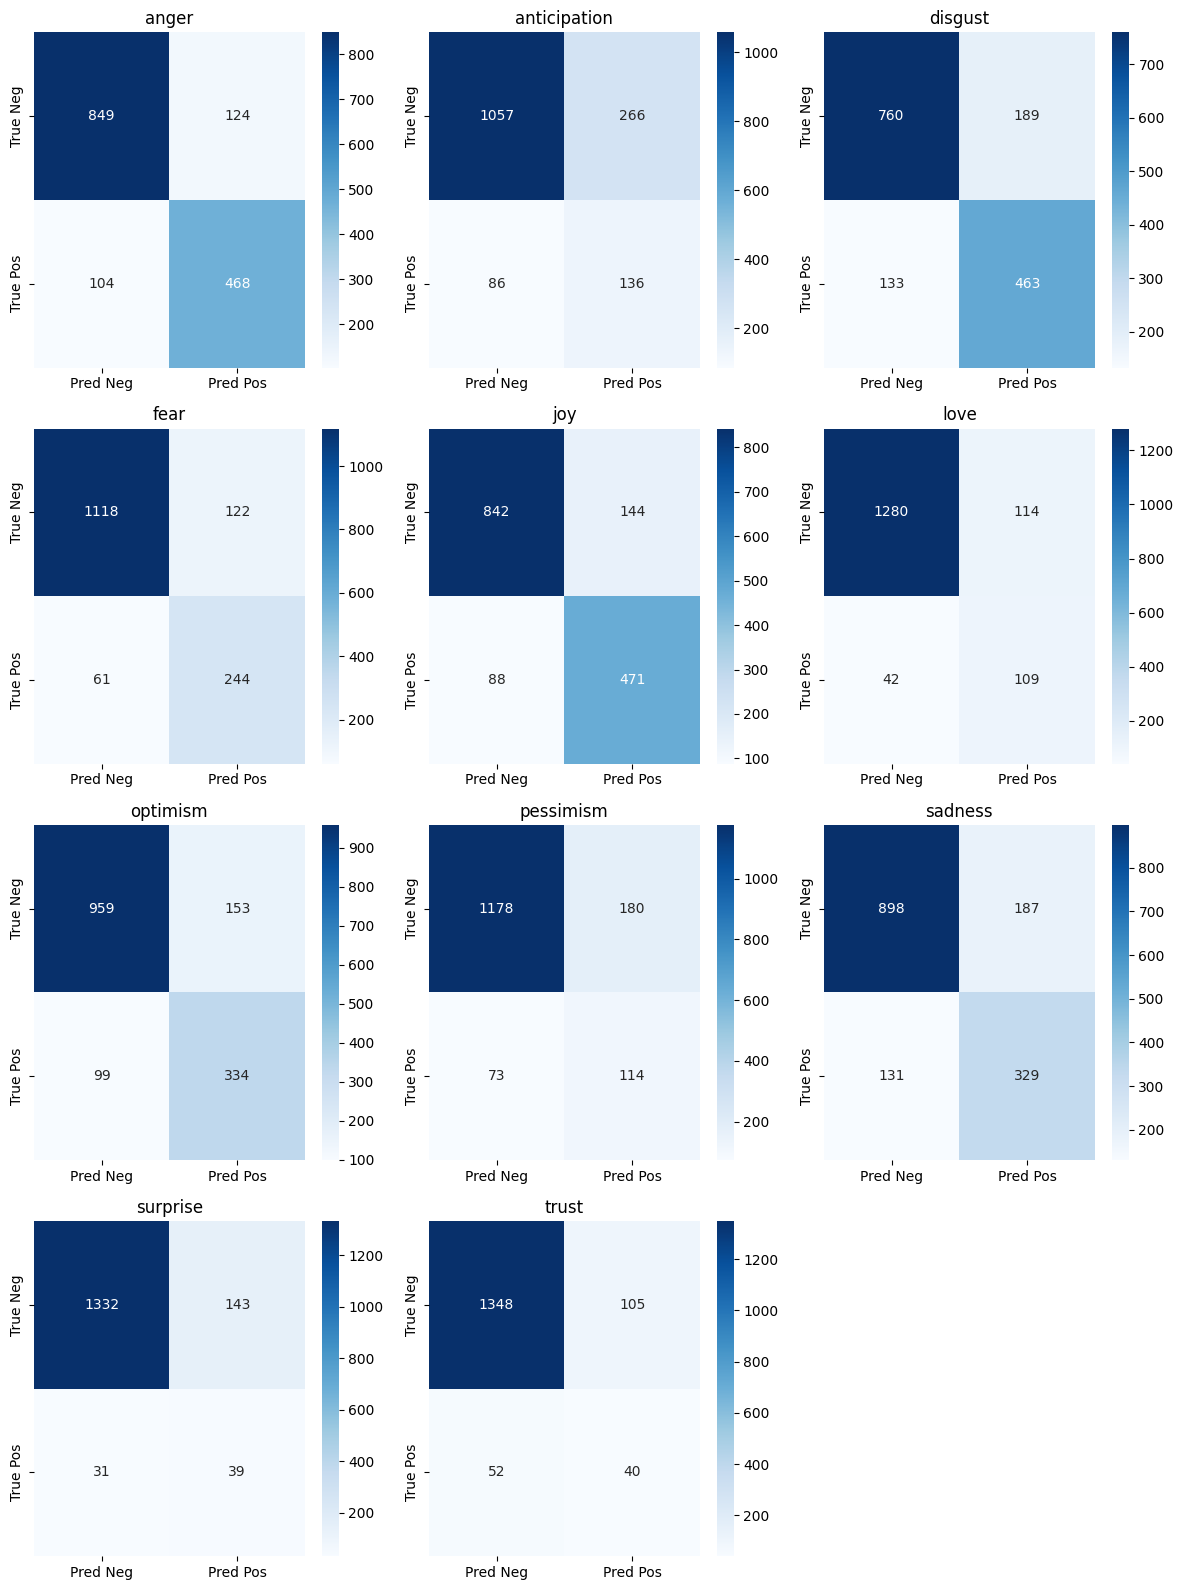

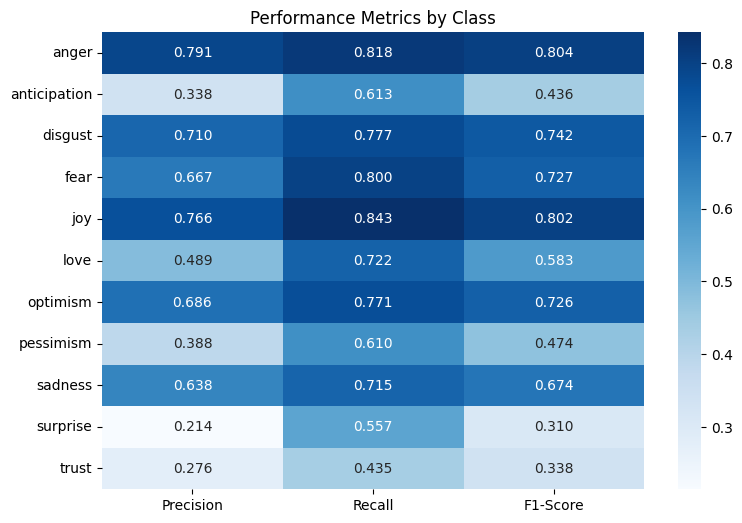

<Figure size 1200x533.333 with 0 Axes>

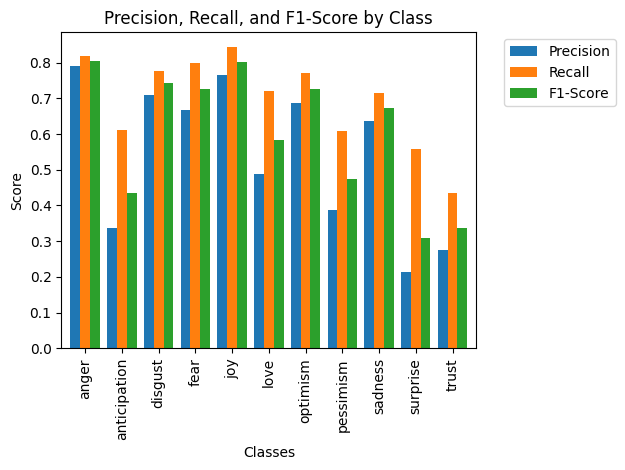

{'macro_avg': {'precision': 0.5419647879275767,
  'recall': 0.6963819558030693,
  'f1': 0.6014463703266459},
 'per_class': {'Precision': {'anger': 0.7905405405405406,
   'anticipation': 0.3383084577114428,
   'disgust': 0.7101226993865031,
   'fear': 0.6666666666666666,
   'joy': 0.7658536585365854,
   'love': 0.48878923766816146,
   'optimism': 0.6858316221765913,
   'pessimism': 0.3877551020408163,
   'sadness': 0.6375968992248062,
   'surprise': 0.21428571428571427,
   'trust': 0.27586206896551724},
  'Recall': {'anger': 0.8181818181818182,
   'anticipation': 0.6126126126126126,
   'disgust': 0.7768456375838926,
   'fear': 0.8,
   'joy': 0.8425760286225402,
   'love': 0.7218543046357616,
   'optimism': 0.7713625866050808,
   'pessimism': 0.6096256684491979,
   'sadness': 0.7152173913043478,
   'surprise': 0.5571428571428572,
   'trust': 0.43478260869565216},
  'F1-Score': {'anger': 0.8041237113402062,
   'anticipation': 0.4358974358974359,
   'disgust': 0.7419871794871795,
   'fear'

In [37]:
# Plot evaluation metrics for test set
multilabel_evaluation(y_true=val_labels, y_pred=val_dataset_preds, class_names=label_names)

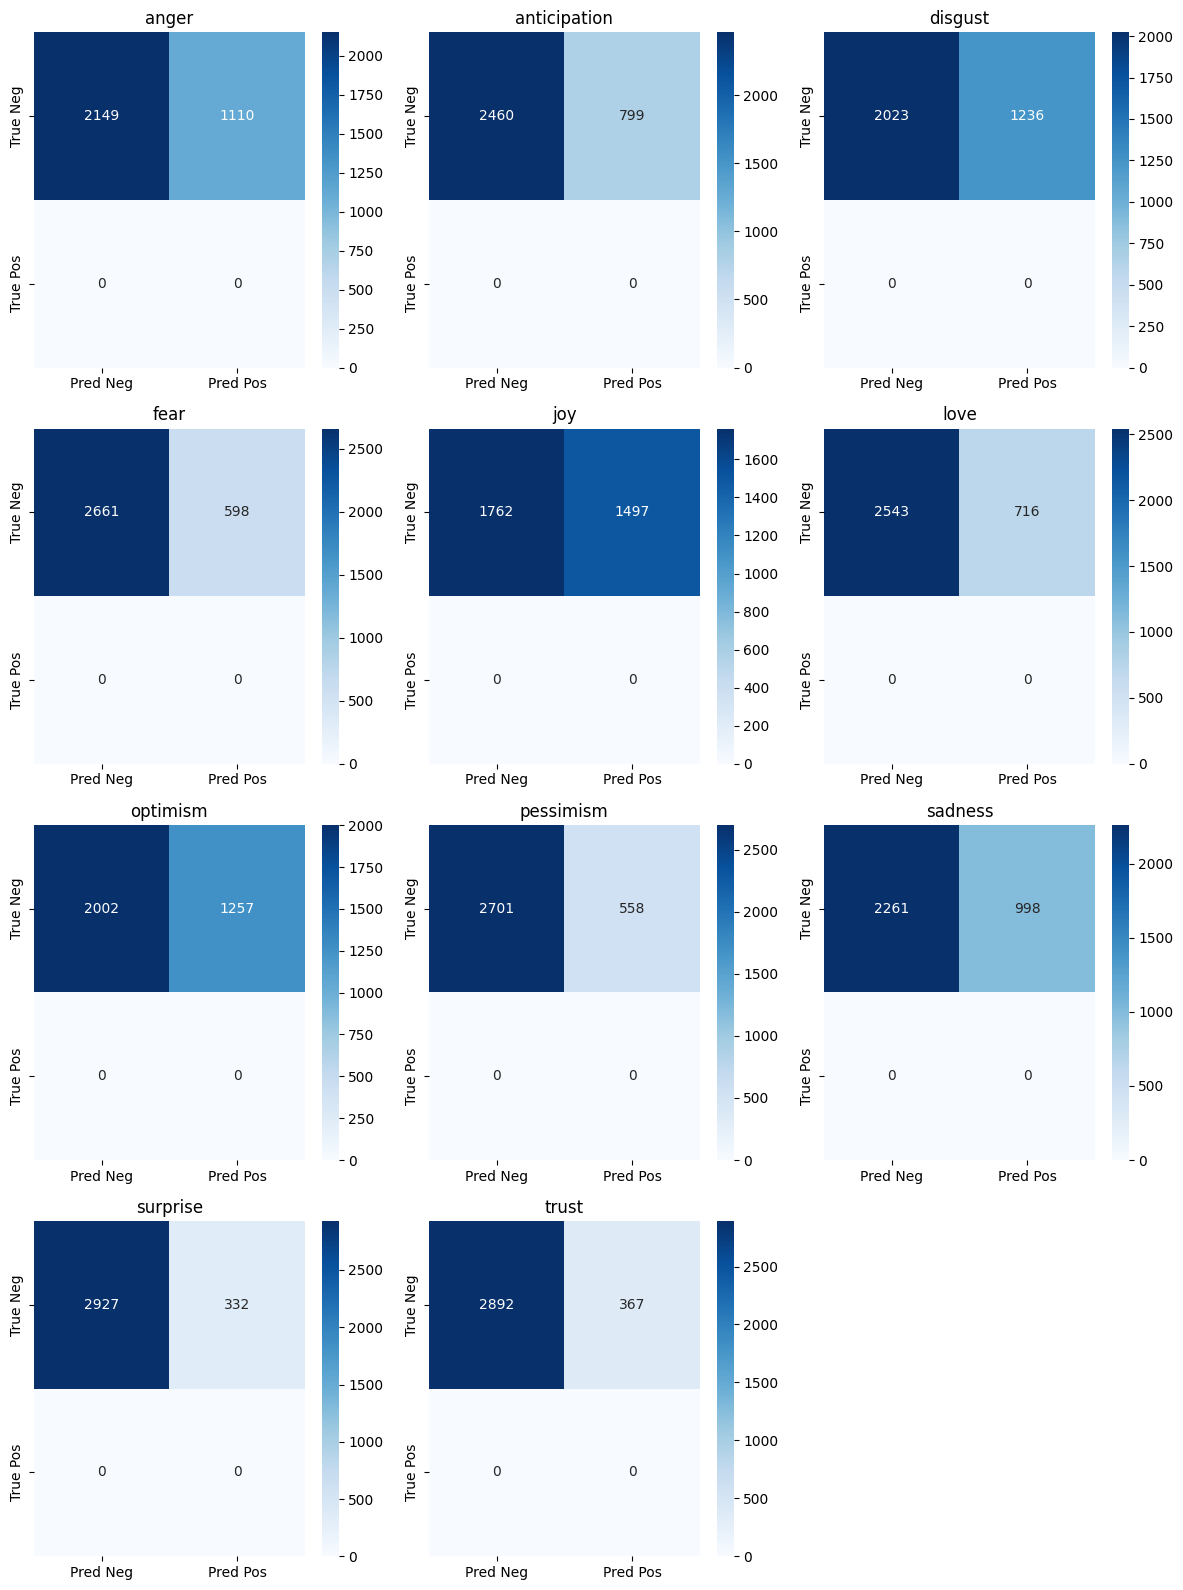

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


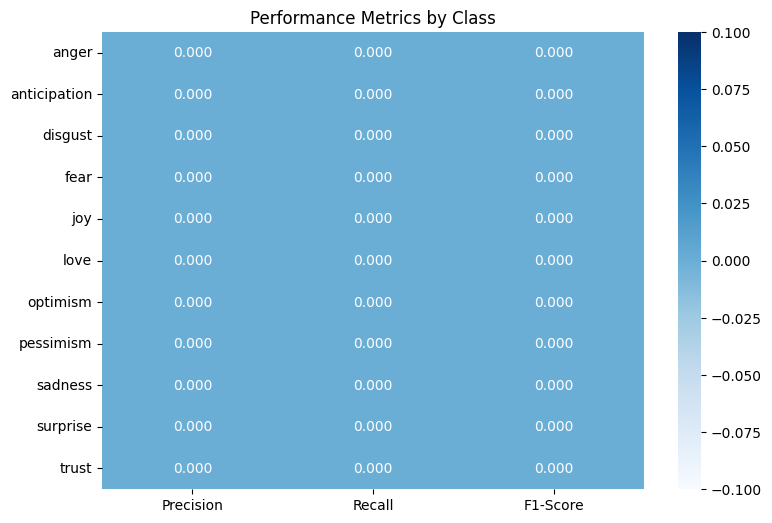

<Figure size 1200x533.333 with 0 Axes>

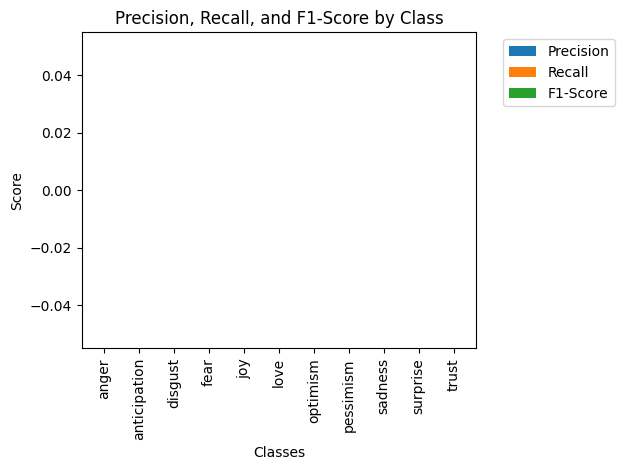

{'macro_avg': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'per_class': {'Precision': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0}}}

In [38]:
# Plot evaluation metrics for test set
multilabel_evaluation(y_true=test_labels, y_pred=test_preds, class_names=label_names)

In [39]:
# Best checkpoint identification for inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 800.


In [40]:
# Convert predictions and IDs to a DataFrame
test_ids = df_test["ID"].values  # Assuming you have df_test loaded with the test dataset including the ID column

# Convert predictions to a DataFrame
preds_df = pd.DataFrame(test_preds, columns=label_names)
preds_df.insert(0, "ID", test_ids)  # Insert IDs as the first column

In [42]:
# Save the DataFrame as a CSV file
preds_df.to_csv("Google_Gemma_2b_2.csv", index=False)
print("File saved as Google_Gemma_2b_2.csv")

File saved as Google_Gemma_2b_2.csv
